In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA

In [2]:
def adf_fuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic','p-value','Lags Used','Number of Observations Used']
    for label,value in zip(labels,result):
        print(label,':',str(value))

In [3]:
ts = pd.read_csv('original_series.csv')
ts.index = np.arange(1,len(ts)+1)

In [4]:
ts.head()

,0
1,956.438486
2,7284.907174
3,11357.870166
4,13622.652007
5,17137.455304


Text(0, 0.5, 'Views')

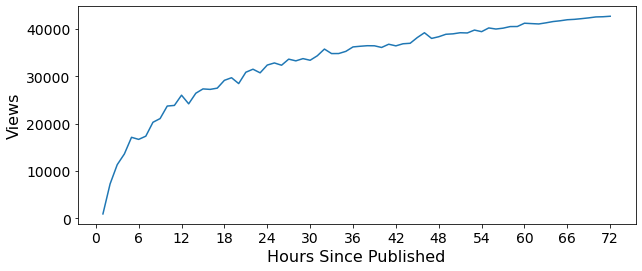

In [5]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6),fontsize=14)
plt.xlabel('Hours Since Published',fontsize=16)
plt.yticks(np.arange(0,50000,10000),fontsize=14)
plt.ylabel('Views',fontsize=16)

### Original Series: $v_t$
#### (1) Normalize ($v_t \rightarrow n_t$): $n_t = \frac{v_t - \mu}{\sigma}$
#### (2) Exponentiate ($n_t \rightarrow e_t$): $e_t = e^{n_t}$
#### (3) First Difference ($e_t \rightarrow d_t$): $d_t = e_t - e_{t-1}$
####  $d_t = e^{\frac{v_t - \mu}{\sigma}} - e^{\frac{v_{t-1} - \mu}{\sigma}}$¶ 

### Normalize

In [6]:
mu = ts.mean()
sigma = ts.std()

norm_ts = (ts - mu)/sigma

In [7]:
norm_ts.head()

,0
1,-3.534311
2,-2.838702
3,-2.391012
4,-2.142073
5,-1.755735


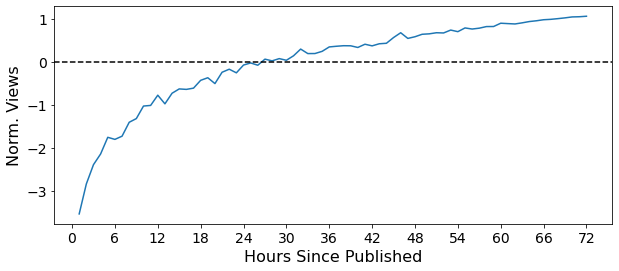

In [8]:
plt.figure(figsize=(10,4))
plt.plot(norm_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-3,2), fontsize=14)
plt.ylabel('Norm. Views', fontsize=16)

plt.axhline(0, color='k', linestyle='--')

In [9]:
exp_ts = np.exp(norm_ts)
exp_ts.head()

,0
1,0.029179
2,0.058502
3,0.091537
4,0.117411
5,0.172780


Text(0, 0.5, 'Exp. Norm. Views')

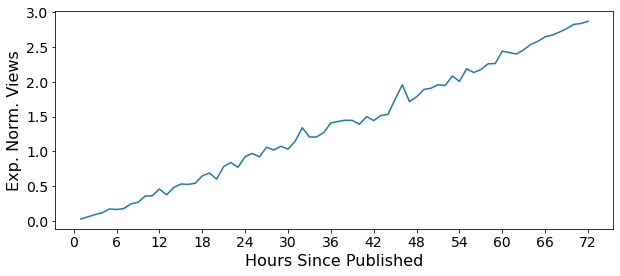

In [10]:
plt.figure(figsize=(10,4))
plt.plot(exp_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,3.5,.5), fontsize=14)
plt.ylabel('Exp. Norm. Views', fontsize=16)

In [11]:
adf_fuller_test(exp_ts)

ADF Test Statistic : 1.552187731184528
p-value : 0.9977068040658765
Lags Used : 8
Number of Observations Used : 63


### First Difference

In [12]:
diff_ts = exp_ts.diff().dropna()
diff_ts.head()

,0
2,0.029323
3,0.033035
4,0.025874
5,0.055369
6,-0.008117


Text(0, 0.5, 'First Diff. \nExp. Norm. Views')

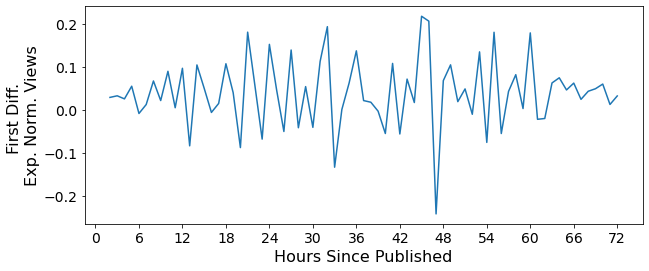

In [13]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

In [14]:
adf_fuller_test(diff_ts)

ADF Test Statistic : -4.920139322026002
p-value : 3.1859452076187765e-05
Lags Used : 7
Number of Observations Used : 63


## FIT AR model

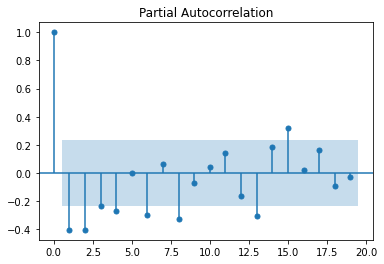

In [15]:
plot_pacf(diff_ts)
plt.show()

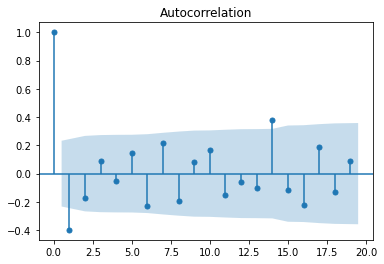

In [16]:
plot_acf(diff_ts)
plt.show()

In [17]:
model = ARMA(diff_ts,order=(4,1))

C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\dasssvis\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupport

In [18]:
model_fit = model.fit()

### Predict Out 3 hrs

In [19]:
predict = model_fit.forecast(3)

predictions = predict[0]
lower_bound = predict[2][:,0]
upper_bound = predict[2][:,1]
predict

(array([0.04562223, 0.0409056 , 0.04115993]),
 array([0.06324201, 0.07895415, 0.07975093]),
 array([[-0.07832984,  0.16957429],
        [-0.11384169,  0.19565289],
        [-0.11514902,  0.19746888]]))

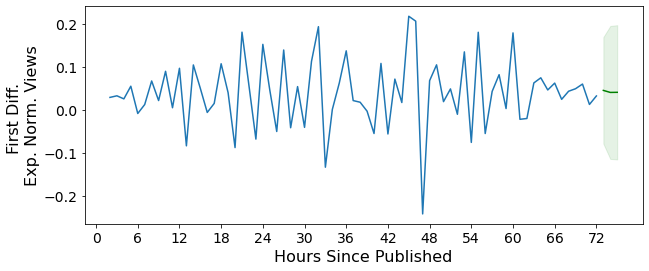

In [20]:
plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(-0.2,0.3,.1), fontsize=14)
plt.ylabel('First Diff. \nExp. Norm. Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), predictions, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), lower_bound, upper_bound, color='g', alpha=0.1)

### In order to predict through original series we have to undo the transformation

## Undo Transformations: ($\hat{d}_{t+1} \rightarrow \hat{v}_{t+1}$)
#### $\hat{v}_{t+1} = \sigma \ln(\hat{d}_{t+1} + e^{\frac{v_t - \mu}{\sigma}}) + \mu$

In [21]:
def undo_transformations(predictions, series, mu, sigma):
    first_pred = sigma*np.log(predictions[0] + np.exp((series.iloc[-1]-mu)/sigma)) + mu
    orig_predictions = [first_pred]
    
    for i in range(len(predictions[1:])):
        next_pred = sigma*np.log(predictions[i+1] + np.exp((orig_predictions[-1]-mu)/sigma)) + mu
        orig_predictions.append(next_pred)
    
    return np.array(orig_predictions).flatten()

In [22]:
orig_preds = undo_transformations(predictions, ts, mu, sigma)
orig_lower_bound = undo_transformations(lower_bound, ts, mu, sigma)
orig_upper_bound = undo_transformations(upper_bound, ts, mu, sigma)

In [23]:
orig_preds

array([42853.79782104, 42980.44256536, 43106.11979582])

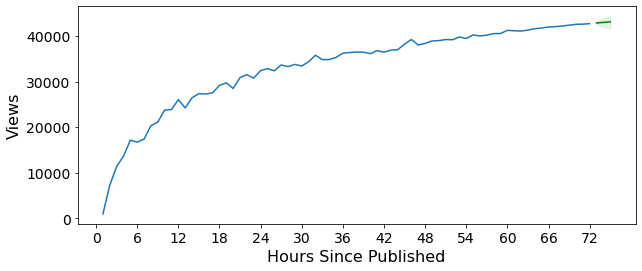

In [24]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78,6), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(0,50000,10000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)

(40000.0, 45000.0)

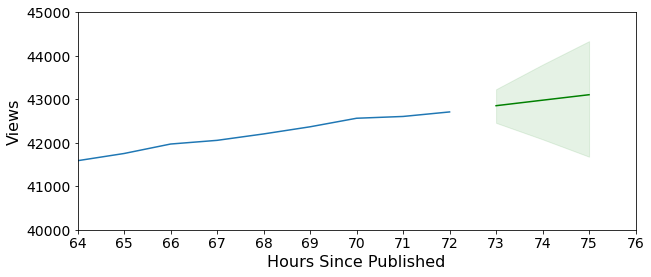

In [25]:
plt.figure(figsize=(10,4))
plt.plot(ts)

plt.xticks(np.arange(0,78), fontsize=14)
plt.xlabel('Hours Since Published', fontsize=16)

plt.yticks(np.arange(40000,46000,1000), fontsize=14)
plt.ylabel('Views', fontsize=16)

plt.plot(np.arange(len(ts)+1, len(ts)+4), orig_preds, color='g')
plt.fill_between(np.arange(len(ts)+1, len(ts)+4), orig_lower_bound, orig_upper_bound, color='g', alpha=0.1)
plt.xlim(64,76)
plt.ylim(40000, 45000)